In [1]:
# noise sources: flux variations, orientiation angle noise, 

# fitting params: (albedo*polarization fraction), {Omega, inclination} or {apparent inc, orbAxisAng angle}
# additional real params: Q+U+V offsets

# need to do a disk integration since there isn't a single path that light takes
#    - need to account for angles spanning the visible portion of the illuminated hemisphere

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import EPPE_Simulator as eppe
import astropy.constants as const
import time

# from EPPE_Simulator import cross_match
# cross_match.cross_match_tables()

In [3]:
expTime = 1
intTime = 10*3*24.

In [4]:
systems = eppe.Systems(load=True)
# mission = eppe.EPPE(rad=0.8) # POMM
mission = eppe.EPPE() # EPPE

# tic = time.time()
# stokesCurves = mission.observe_polarization(systems, expTime, intTime)
# toc = time.time()
# print('Took', int(np.rint(toc-tic)), 'seconds')

FOMs = mission.compute_FOM(systems, expTime, intTime)
# stokesCurves_ideal = mission.observe_polarization(systems, expTime, intTime, photonNoise=False, pStart=0)
# fps, fstars, times, phases = mission.observe_photometric(systems, expTime, intTime, photonNoise=True, pStart=0)

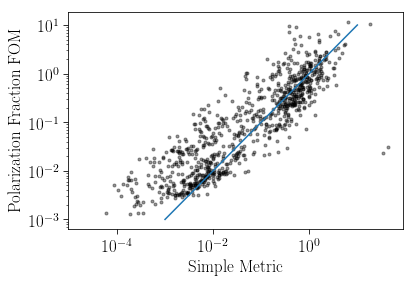

In [6]:
Ein = (systems.catalogue['teff']*np.sqrt(systems.catalogue['rstar']/systems.catalogue['a']))**4
metric = 0.25e-11*Ein*(systems.catalogue['rp']/systems.catalogue['rstar'])**2
plt.loglog(metric, FOMs, '.', c='k', alpha=0.4)
plt.plot([1e-3,1e1], [1e-3,1e1])
plt.ylabel(r'$\rm Polarization~Fraction~FOM$')
plt.xlabel(r'$\rm Simple~Metric$')
plt.show()

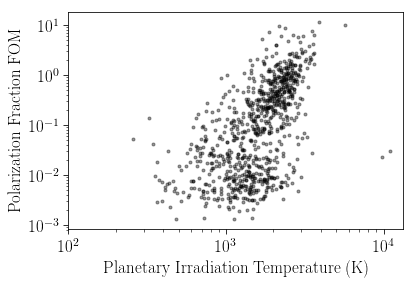

In [7]:
plt.loglog(systems.catalogue['teff']*np.sqrt(systems.catalogue['rstar']/systems.catalogue['a']), FOMs, '.', c='k', alpha=0.4)
plt.ylabel(r'$\rm Polarization~Fraction~FOM$')
plt.xlabel(r'$\rm Planetary~Irradiation~Temperature~(K)$')
plt.xlim(1e2)
plt.show()

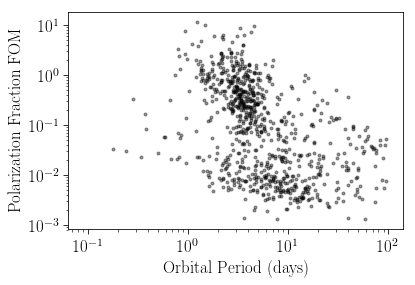

In [8]:
plt.loglog(systems.catalogue['per'], FOMs, '.', c='k', alpha=0.4)
plt.ylabel(r'$\rm Polarization~Fraction~FOM$')
plt.xlabel(r'$\rm Orbital~Period~(days)$')
plt.show()

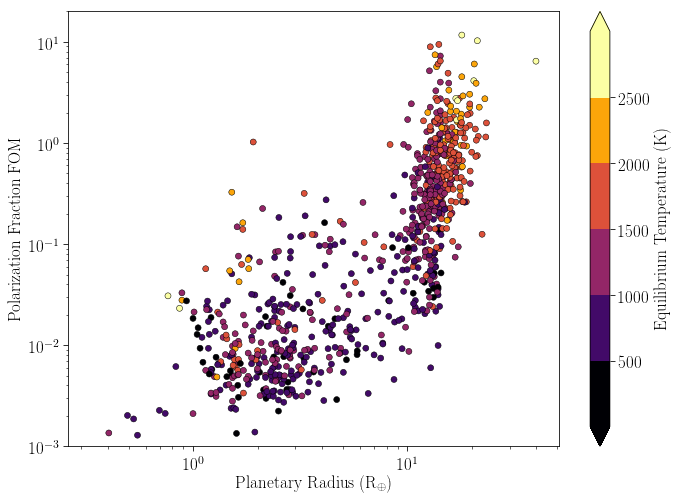

In [121]:
teq = 0.25**0.25*systems.catalogue['teff']*np.sqrt(systems.catalogue['rstar']/systems.catalogue['a'])

fig = plt.figure(figsize=(11,8))
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3,2e1)
ax.set_ylabel(r'$\rm Polarization~Fraction~FOM$')
ax.set_xlabel(r'$\rm Planetary~Radius~(R_{\oplus})$')

cmap = plt.get_cmap('inferno', 6)

scat = ax.scatter(x=systems.catalogue['rp']/const.R_earth.value, y=FOMs, c=teq, marker='o', cmap=cmap, vmin=0, vmax=3000, edgecolor='k', linewidth=0.5)
cbar = fig.colorbar(scat, ax=ax, label=r'$\rm Equilibrium~Temperature~(K)$', extend='both')
cbar.set_ticks([500,1000,1500,2000,2500])

plt.show()
plt.close(fig)

In [7]:
# i = 1
i = np.where(systems.catalogue['name']=='WASP-12 b')[0][0]
# i = np.where(systems.catalogue['name']=='HD 189733 b')[0][0]
# i = np.where(systems.catalogue['name']=='HD 209458 b')[0][0]
# i = np.where(systems.catalogue['name']=='KELT-7 b')[0][0]
# i = np.where(systems.catalogue['name']=='KELT-9 b')[0][0]

In [8]:
print('Name:', systems.catalogue['name'][i])
print('Period:', np.round(systems.catalogue['per'][i], 2), 'days')
print('Transit Depth: '+str(np.round((systems.catalogue['rp'][i]/systems.catalogue['rstar'][i])**2*100, 3))+'%')
print('Equilibrium Temperature: '+str(int(np.rint((systems.catalogue['teff'][i]*np.sqrt(systems.catalogue['rstar'][i]/systems.catalogue['a'][i])))))+' K')
print('Distance: '+str(int(np.rint(systems.catalogue['dist'][i]/const.pc.value)))+' pc')
print('Radius: '+str(np.round(systems.catalogue['rp'][i]/const.R_jup.value, 2))+' Rjup')

Name: WASP-12 b
Period: 1.09 days
Transit Depth: 1.384%
Equilibrium Temperature: 3541 K
Distance: 432 pc
Radius: 1.82 Rjup


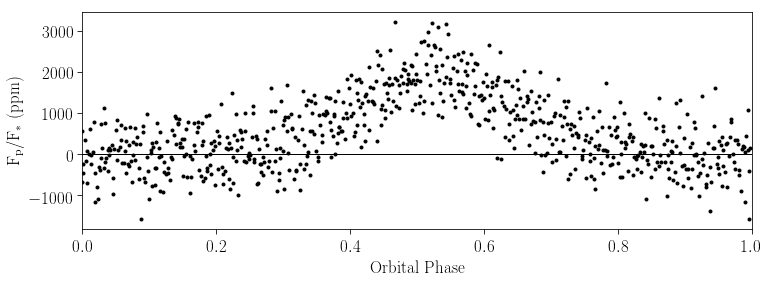

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))
ax.plot(stokesCurves[i][-1], (stokesCurves[i][0]/np.median(fstars[i])-1)*1e6, '.', c='k')
ax.plot([0,1], [0,0], lw=1, c='k')
ax.set_ylabel(r'$\rm F_p/F_*~({\rm ppm})$')
ax.set_xlabel(r'$\rm Orbital~Phase$')
ax.set_xlim(0,1)
plt.show()
plt.close(fig)

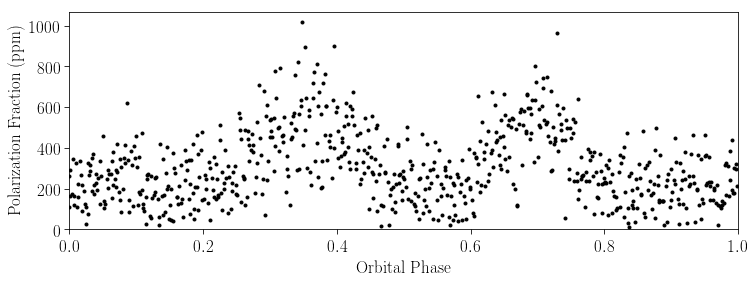

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))
ax.plot(stokesCurves[i][-1], np.sqrt(stokesCurves[i][1]**2+stokesCurves[i][2]**2)/stokesCurves[i][0]*1e6,
        '.', c='k')
ax.set_ylabel(r'$\rm Polarization~Fraction~(ppm)$')
ax.set_xlabel(r'$\rm Orbital~Phase$')
ax.set_xlim(0,1)
ax.set_ylim(0)
plt.show()
plt.close(fig)

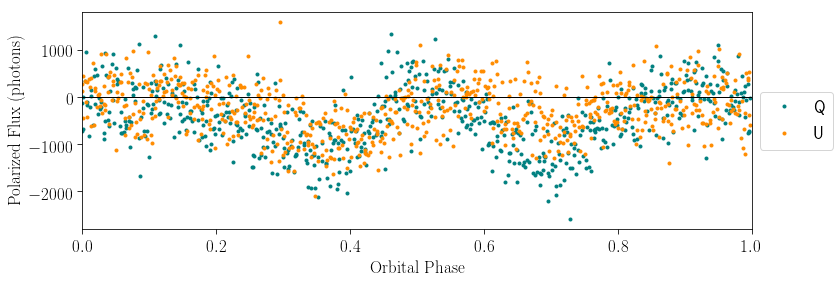

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))
ax.plot(stokesCurves[i][-1], stokesCurves[i][1], '.', c='teal', label='Q')
ax.plot(stokesCurves[i][-1], stokesCurves[i][2], '.', c='darkorange', label='U')
# ax.plot(stokesCurves[i][-1], stokesCurves[i][3], '.', c='green', label='V')
ax.plot([0,1], [0,0], lw=1, c='k')
ax.set_ylabel(r'$\rm Polarized~Flux~(photons)$')
ax.set_xlabel(r'$\rm Orbital~Phase$')
ax.set_xlim(0,1)
ax.legend(loc=6, bbox_to_anchor=(1,0.5))
plt.show()
plt.close(fig)